In [1]:
### setting for remote python debug, such as jupyter or pycharm, to avoid bedtools calling error
### run before "import scglue"
import os
from os import path
import sys
import shutil
import subprocess
bin_dir = path.dirname(sys.executable)
os.environ['PATH'] += os.pathsep + bin_dir
## shutil.which('bedtools')
## subprocess.run(['bedtools', '--help'])

# import pybedtools
# pybedtools.set_bedtools_path('/mnt/disk1/xzhou/anaconda3/envs/PyG/bin/') ## 这里提前设置否则"sortBed"找不到
# # pybedtools.set_bedtools_path('/mnt/disk1/xzhou/code/')
# import importlib
# pybedtools = importlib.reload(pybedtools)
# print(pybedtools.settings.bedtools_version)
# print(pybedtools.helpers._version_2_15_plus_names("sortBed"))
# print(pybedtools.settings._bedtools_installed)

import pandas as pd
import anndata as ad
import networkx as nx
import scanpy as sc
import scglue
from matplotlib import rcParams

/mnt/disk1/xiaojk/anaconda/envs/scGLUE1/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
scglue.plot.set_publication_params()
rcParams["figure.figsize"] = (4, 4)

In [3]:
## from RCTD paper
adata_st = sc.read_h5ad("/mnt/disk1/xzhou/data/multi-omics/Hippocampus/slide-seqv2_Cropped_hippocampus.h5ad")
adata_st.obsm['spatial'] = adata_st.obs[['x', 'y']].values
adata_st.X = adata_st.X.astype(int)  ###### MERFISH的counts不是整数，需要强制取整，否则后面报错
adata_st.var_names_make_unique()
adata_st.layers["counts"] = adata_st.X.copy()

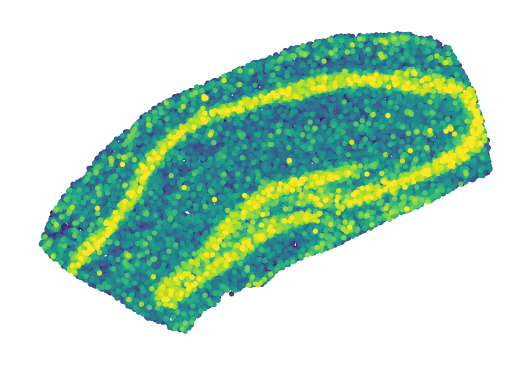

In [4]:
sc.pp.calculate_qc_metrics(adata_st, inplace=True)
# scglue.plot.set_publication_params()
# rcParams["figure.figsize"] = (4, 3)
import matplotlib.pyplot as plt
plt.rcParams['axes.facecolor']='snow'
plt.rcParams['savefig.facecolor']='snow'
_sc = sc.pl.spatial(adata_st, basis="spatial", color="log1p_total_counts", show=False, title = '', colorbar_loc=None,  vmax='p99',frameon=False, spot_size =50) #
_sc[0].axes.get_xaxis().set_visible(False)
_sc[0].axes.get_yaxis().set_visible(False)
plt.show()

In [5]:
sc.pp.highly_variable_genes(adata_st, n_top_genes=2000, flavor="seurat_v3")
sc.pp.normalize_total(adata_st)
sc.pp.log1p(adata_st)
sc.pp.scale(adata_st)
sc.tl.pca(adata_st, n_comps=100, svd_solver="auto")

In [6]:
adata_st.var_names = adata_st.var['features']

In [8]:
rna = adata_st.copy()
rna.obs["domain"] = "Slide-seqV2"
rna.obs["protocol"] = "Slide-seqV2"
rna.obs["dataset"] = "Slide-seqV2"

scglue.data.get_gene_annotation(
    rna, gtf="/mnt/disk1/xiaojk/data/gencode.vM25.chr_patch_hapl_scaff.annotation.gtf.gz",
    gtf_by="gene_name"
)
rna.var["genome"] = "mm10"

rna.var.loc[:, ["chrom", "chromStart", "chromEnd"]].head()

,chrom,chromStart,chromEnd
features,,,
0610005C13Rik,chr7,45567793.0,45575327.0
0610007P14Rik,NaN,NaN,NaN
0610009B22Rik,chr11,51685385.0,51688874.0
0610009E02Rik,chr2,26445695.0,26459390.0
0610009L18Rik,chr11,120348677.0,120351190.0


In [11]:
retained_genes = rna.var.dropna(subset=["chrom", "chromStart", "chromEnd"]).index
rna = rna[:, retained_genes]
rna.var = rna.var.astype({"chromStart": int, "chromEnd": int})
rna

AnnData object with n_obs × n_vars = 17747 × 21163
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'x', 'y', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'domain', 'protocol', 'dataset'
    var: '_index', 'features', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_id', 'gene_type', 'mgi_id', 'havana_gene', 'tag', 'genome'
    uns: 'hvg', 'log1p', 'pca'
    obsm: 'spatial', 'X_pca'
    varm: 'PCs'
    layers: 'counts'

In [12]:
rna.var_names

Index(['0610005C13Rik', '0610009B22Rik', '0610009E02Rik', '0610009L18Rik',
       '0610010F05Rik', '0610010K14Rik', '0610012D04Rik', '0610025J13Rik',
       '0610030E20Rik', '0610031O16Rik',
       ...
       'mt-Tq', 'mt-Tr', 'mt-Ts2', 'mt-Tt', 'mt-Tv', 'n-R5-8s1', 'n-R5s173',
       'n-R5s33', 'n-R5s40', 'n-R5s95'],
      dtype='object', name='features', length=21163)

In [13]:
## An atlas of gene regulatory elements in adult mouse cerebrum.
## 2021 Single-cell chromatin state analysis with Signac.pdf
atac = ad.read_h5ad("/mnt/disk1/xzhou/data/multi-omics/BICCN-master/biccn_8J_8E.h5ad") ##直接用之前的数据
atac.X = atac.raw.X
atac.obs['cell_type'] = atac.obs['SubClass']
atac.var_names = pd.Index([atac.var_names[ii].split("-")[0]+':'+atac.var_names[ii].split("-")[1]+"-"+atac.var_names[ii].split("-")[2] for ii in range(atac.shape[1])])

/mnt/disk1/xiaojk/anaconda/envs/scGLUE1/lib/python3.10/site-packages/anndata/compat/__init__.py:229: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(


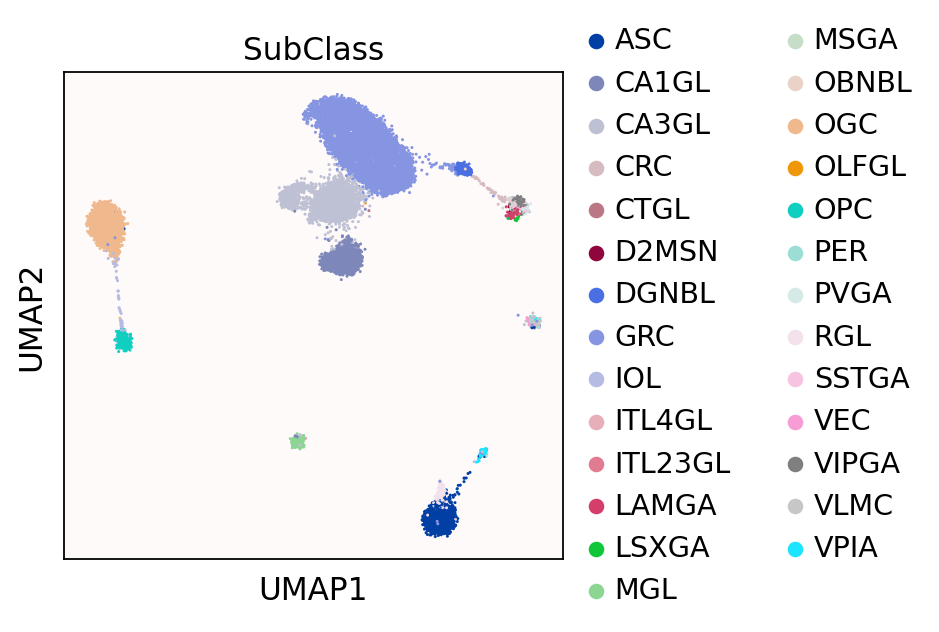

In [14]:
sc.pl.umap(atac, color="SubClass")

In [15]:
chrom = [atac.var_names[ii].split(":")[0] for ii in range(atac.shape[1])]
chrom_pos = [atac.var_names[ii].split(":")[1].split("-") for ii in range(atac.shape[1])]  

In [16]:
var_df = pd.concat([pd.DataFrame(chrom), pd.DataFrame(chrom_pos).loc[:, :1]], axis=1)
var_df.index = atac.var_names
var_df.columns = ["chrom", "chromStart", "chromEnd"]
var_df.index.name = 'peaks'
atac.var = var_df

In [17]:
# ## 注意这里会把RNA的高可变基因传到ATAC中
guidance = scglue.genomics.rna_anchored_guidance_graph(rna, atac, propagate_highly_variable = True)
guidance

window_graph: 100%|██████████| 21163/21163 [00:01<00:00, 14435.54it/s]


In [18]:
scglue.graph.check_graph(guidance, [rna, atac])

[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] check_graph: All checks passed!


In [19]:
atac.var.head()

,chrom,chromStart,chromEnd,highly_variable
peaks,,,,
chr1:3012371-3012843,chr1,3012371,3012843,False
chr1:3094790-3095399,chr1,3094790,3095399,False
chr1:3113044-3113920,chr1,3113044,3113920,False
chr1:3119264-3120628,chr1,3119264,3120628,False
chr1:3216886-3217550,chr1,3216886,3217550,True


In [20]:
from itertools import chain

import anndata as ad
import itertools
import networkx as nx
import pandas as pd
import scanpy as sc
import scglue
import seaborn as sns

from matplotlib import rcParams

In [21]:
scglue.models.configure_dataset(
    rna, "NB", use_highly_variable=True,
    use_layer="counts", use_rep="X_pca"
)
scglue.models.configure_dataset(
    atac, "NB", use_highly_variable=True,
    use_rep="X_lsi"
)

In [22]:
guidance_hvf = guidance.subgraph(chain(
    rna.var.query("highly_variable").index,
    atac.var.index
)).copy()
# atac.var.query("highly_variable").index

In [23]:
atac.X[:5,:50].max()

1.0

In [24]:
glue = scglue.models.fit_SCGLUE(
    {"rna": rna, "atac": atac}, guidance_hvf,
    fit_kws={"directory": "glue"}
)

[INFO] fit_SCGLUE: Pretraining SCGLUE model...
[INFO] autodevice: Using GPU 3 as computation device.
[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] SCGLUEModel: Setting `graph_batch_size` = 36537
[INFO] SCGLUEModel: Setting `max_epochs` = 101
[INFO] SCGLUEModel: Setting `patience` = 9
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 5
[INFO] SCGLUETrainer: Using training directory: "glue/pretrain"
[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.217, 'g_kl': 0.002, 'g_elbo': 0.218, 'x_rna_nll': 0.101, 'x_rna_kl': 0.003, 'x_rna_elbo': 0.104, 'x_atac_nll': 0.103, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.104, 'dsc_loss': 0.691, 'vae_loss': 0.216, 'gen_loss': 0.182}, val={'g_nll': 0.215, 'g_kl': 0.002, 'g_elbo': 0.217, 'x_rna_nll': 0.106, 'x_rna_kl': 0.003, 'x_rna_elbo': 0.109, 'x_atac_nll': 0.101, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.102, 'dsc

2023-09-22 20:26:47,679 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "38"...
[INFO] fit_SCGLUE: Estimating balancing weight...
[INFO] estimate_balancing_weight: Clustering cells...


/mnt/disk1/xiaojk/anaconda/envs/scGLUE1/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/mnt/disk1/xiaojk/anaconda/envs/scGLUE1/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/mnt/disk1/xiaojk/anaconda/envs/scGLUE1/lib/python3.10/site-

[INFO] estimate_balancing_weight: Matching clusters...
[INFO] estimate_balancing_weight: Matching array shape = (16, 22)...
[INFO] estimate_balancing_weight: Estimating balancing weight...


/mnt/disk1/xiaojk/anaconda/envs/scGLUE1/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/mnt/disk1/xiaojk/anaconda/envs/scGLUE1/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


[INFO] fit_SCGLUE: Fine-tuning SCGLUE model...
[INFO] check_graph: Checking variable coverage...
[INFO] check_graph: Checking edge attributes...
[INFO] check_graph: Checking self-loops...
[INFO] check_graph: Checking graph symmetry...
[INFO] SCGLUEModel: Setting `graph_batch_size` = 36537
[INFO] SCGLUEModel: Setting `align_burnin` = 17
[INFO] SCGLUEModel: Setting `max_epochs` = 101
[INFO] SCGLUEModel: Setting `patience` = 9
[INFO] SCGLUEModel: Setting `reduce_lr_patience` = 5
[INFO] SCGLUETrainer: Using training directory: "glue/fine-tune"
[INFO] SCGLUETrainer: [Epoch 10] train={'g_nll': 0.202, 'g_kl': 0.002, 'g_elbo': 0.204, 'x_rna_nll': 0.101, 'x_rna_kl': 0.003, 'x_rna_elbo': 0.104, 'x_atac_nll': 0.102, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.103, 'dsc_loss': 0.687, 'vae_loss': 0.215, 'gen_loss': 0.181}, val={'g_nll': 0.2, 'g_kl': 0.002, 'g_elbo': 0.202, 'x_rna_nll': 0.101, 'x_rna_kl': 0.003, 'x_rna_elbo': 0.103, 'x_atac_nll': 0.103, 'x_atac_kl': 0.001, 'x_atac_elbo': 0.103, 'dsc_loss':

2023-09-22 20:32:23,985 ignite.handlers.early_stopping.EarlyStopping INFO: EarlyStopping: Stop training


[INFO] EarlyStopping: Restoring checkpoint "33"...


In [25]:
dx = scglue.models.integration_consistency(
    glue, {"rna": rna, "atac": atac}, guidance_hvf
)
dx

[INFO] integration_consistency: Using layer "counts" for modality "rna"
[INFO] integration_consistency: Selecting aggregation "sum" for modality "rna"
[INFO] integration_consistency: Selecting aggregation "sum" for modality "atac"
[INFO] integration_consistency: Selecting log-norm preprocessing for modality "rna"
[INFO] integration_consistency: Selecting log-norm preprocessing for modality "atac"
[INFO] get_metacells: Clustering metacells...


/mnt/disk1/xiaojk/anaconda/envs/scGLUE1/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md
/mnt/disk1/xiaojk/anaconda/envs/scGLUE1/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 10 common metacells...
[INFO] get_metacells: Clustering metacells...


/mnt/disk1/xiaojk/anaconda/envs/scGLUE1/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md
/mnt/disk1/xiaojk/anaconda/envs/scGLUE1/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 20 common metacells...
[INFO] get_metacells: Clustering metacells...


/mnt/disk1/xiaojk/anaconda/envs/scGLUE1/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md
/mnt/disk1/xiaojk/anaconda/envs/scGLUE1/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 50 common metacells...
[INFO] get_metacells: Clustering metacells...


/mnt/disk1/xiaojk/anaconda/envs/scGLUE1/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md
/mnt/disk1/xiaojk/anaconda/envs/scGLUE1/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 99 common metacells...
[INFO] get_metacells: Clustering metacells...


/mnt/disk1/xiaojk/anaconda/envs/scGLUE1/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
[WARNING] get_metacells: `faiss` is not installed, using `sklearn` instead... This might be slow with a large number of cells. Consider installing `faiss` following the guide from https://github.com/facebookresearch/faiss/blob/main/INSTALL.md
/mnt/disk1/xiaojk/anaconda/envs/scGLUE1/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[INFO] get_metacells: Aggregating metacells...
[INFO] metacell_corr: Computing correlation on 200 common metacells...


,n_meta,consistency
0,10,0.260441
1,20,0.216928
2,50,0.170167
3,100,0.139271
4,200,0.129945


In [27]:
combined.obsm['X_glue'].shape

NameError: name 'combined' is not defined

/mnt/disk1/xiaojk/anaconda/envs/scGLUE1/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/mnt/disk1/xiaojk/anaconda/envs/scGLUE1/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/mnt/disk1/xiaojk/anaconda/envs/scGLUE1/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


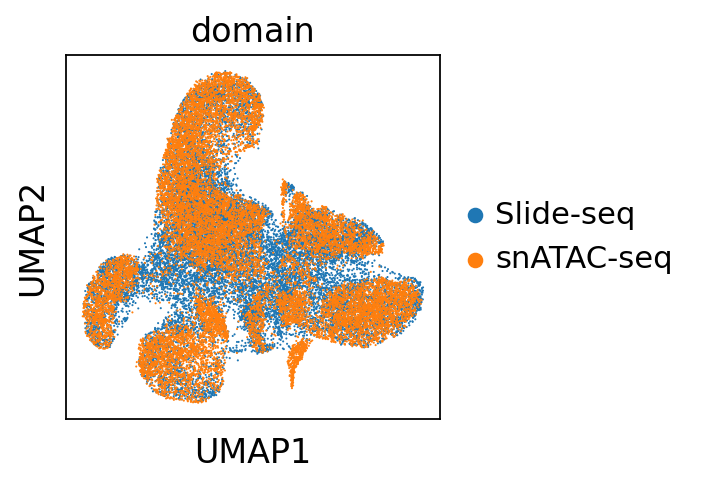

In [28]:
rna.obsm["X_glue"] = glue.encode_data("rna", rna)
atac.obsm["X_glue"] = glue.encode_data("atac", atac)

# combined = ad.concat([rna, atac])
combined = ad.concat([rna, atac], label="domain", keys=['Slide-seq', 'snATAC-seq'])

sc.pp.neighbors(combined, use_rep="X_glue", metric="cosine")
sc.tl.umap(combined)

sc.settings.set_figure_params(frameon=True, fontsize=15, facecolor='white', figsize=(3, 3)) #dpi=300, 
sc.pl.umap(combined, color=["domain"], wspace=0.9)

/mnt/disk1/xiaojk/anaconda/envs/scGLUE1/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/tmp/ipykernel_264609/3558588810.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  combined_atac.obs['cell_type'] = atac.obs['cell_type']
/mnt/disk1/xiaojk/anaconda/envs/scGLUE1/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/mnt/disk1/xiaojk/anaconda/envs/scGLUE1/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/mnt/disk1/xiaojk/anaconda/envs/scGLUE1/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModifi

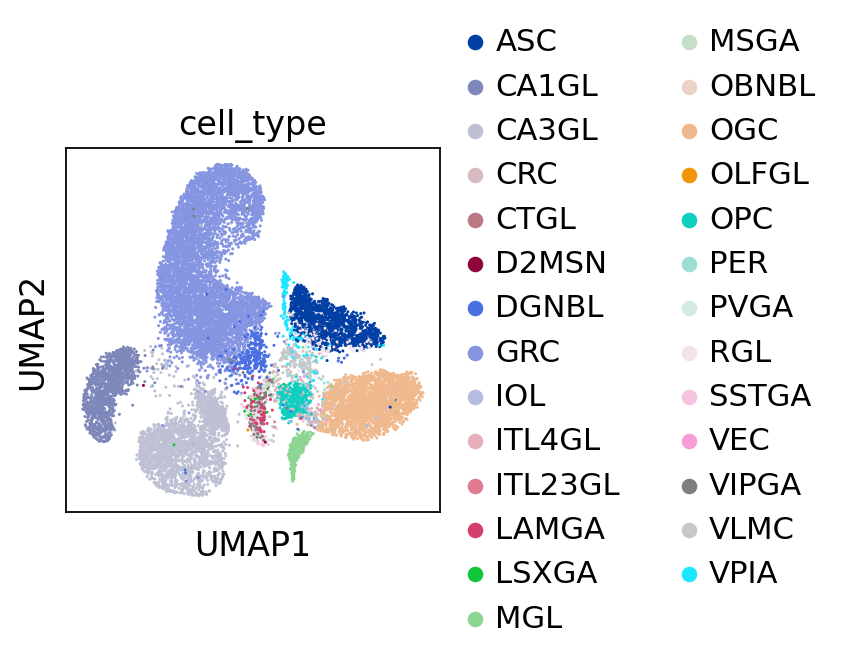

In [29]:
combined_atac = combined[combined.obs['domain']=="snATAC-seq"]
combined_atac.obs['cell_type'] = atac.obs['cell_type']
sc.pl.umap(combined_atac, color=["cell_type"], show=True)

In [30]:
feature_embeddings = glue.encode_graph(guidance_hvf)
feature_embeddings = pd.DataFrame(feature_embeddings, index=glue.vertices)
feature_embeddings.iloc[:5, :5]

,0,1,2,3,4
1110017D15Rik,-0.013589,-0.574130,0.062574,-0.017322,-0.001441
1500012K07Rik,-0.008623,-0.803943,0.038002,-0.021884,-0.005168
1700001L05Rik,-0.012693,-0.305774,0.052300,-0.010071,0.006184
1700007K13Rik,-0.011771,-0.413724,0.052740,-0.014096,0.001089
1700012B09Rik,-0.011761,-0.579454,0.038113,-0.015462,-0.003775


In [31]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(atac.obsm["X_glue"], atac.obs["cell_type"])
print(neigh.predict(rna.obsm["X_glue"]))
print(neigh.predict_proba(rna.obsm["X_glue"]))

['CA3GL' 'CA3GL' 'CA1GL' ... 'GRC' 'OGC' 'GRC']
[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [32]:
import numpy as np
rna.obsm["tangram_ct_pred"] = pd.DataFrame(neigh.predict_proba(rna.obsm["X_glue"]),
                                           index=rna.obs_names, columns=np.sort(list(atac.obs["cell_type"].unique())))

In [33]:
def construct_obs_plot(df_plot, adata, perc=0, suffix=None):
    # clip
    df_plot = df_plot.clip(df_plot.quantile(perc), df_plot.quantile(1 - perc), axis=1)

    # normalize
    df_plot = (df_plot - df_plot.min()) / (df_plot.max() - df_plot.min())

    if suffix:
        df_plot = df_plot.add_suffix(" ({})".format(suffix))
    adata.obs = pd.concat([adata.obs, df_plot], axis=1)
    
    
def plot_cell_annotation_sc(
    adata_sp, 
    annotation_list, 
    x="x", 
    y="y", 
    spot_size=None, 
    scale_factor=None, 
    perc=0,
    alpha_img=1.0,
    bw=False,
    ax=None
):
        
    # remove previous df_plot in obs
    adata_sp.obs.drop(annotation_list, inplace=True, errors="ignore", axis=1)

    # construct df_plot
    df = adata_sp.obsm["tangram_ct_pred"][annotation_list]
    construct_obs_plot(df, adata_sp, perc=perc)
    
    #non visium data 
    if 'spatial' not in adata_sp.obsm.keys():
        #add spatial coordinates to obsm of spatial data 
        coords = [[x,y] for x,y in zip(adata_sp.obs[x].values,adata_sp.obs[y].values)]
        adata_sp.obsm['spatial'] = np.array(coords)
    
    if 'spatial' not in adata_sp.uns.keys() and spot_size == None and scale_factor == None:
        raise ValueError("Spot Size and Scale Factor cannot be None when ad_sp.uns['spatial'] does not exist")
    
    #REVIEW
    if 'spatial' in adata_sp.uns.keys() and spot_size != None and scale_factor != None:
        raise ValueError("Spot Size and Scale Factor should be None when ad_sp.uns['spatial'] exists")
    
    sc.pl.spatial(
        adata_sp, color=annotation_list, cmap="viridis", show=False, frameon=False, spot_size=spot_size,
        scale_factor=scale_factor, alpha_img=alpha_img, bw=bw, ax=ax, colorbar_loc=None,ncols=5,wspace=0
    )

    adata_sp.obs.drop(annotation_list, inplace=True, errors="ignore", axis=1)

In [34]:
atac.obs['cell_type'].unique()

['ASC', 'OPC', 'OGC', 'RGL', 'MGL', ..., 'CRC', 'OBNBL', 'LSXGA', 'DGNBL', 'D2MSN']
Length: 27
Categories (27, object): ['ASC', 'CA1GL', 'CA3GL', 'CRC', ..., 'VEC', 'VIPGA', 'VLMC', 'VPIA']

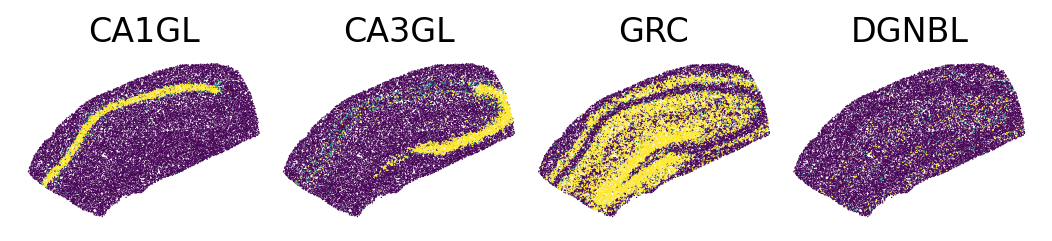

In [35]:
# tg.project_cell_annotations(ad_map, adata_st, annotation="cell_subclass")
#### 'Pvalb', 'Sst',
##这里由于是FISH数据，每个spot都会对应一个细胞，如果是Visium，则需要对应多个细胞
annotation_list = ['CA1GL', 'CA3GL', 'GRC', 'DGNBL']
# annotation_list = list(atac.obs["cell_type"].unique()) #
sc.settings.set_figure_params(frameon=True, fontsize=15, facecolor='white',figsize=(2, 2)) #dpi=300, 
### plot_cell_annotation_sc(adata_st, annotation_list, x='x', y='y', spot_size= 60, scale_factor=0.1, perc=0.001)
plot_cell_annotation_sc(rna.copy(), annotation_list, perc=0.02, spot_size= 25)

In [38]:
rna

AnnData object with n_obs × n_vars = 17747 × 21163
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'x', 'y', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'domain', 'protocol', 'dataset', 'balancing_weight'
    var: '_index', 'features', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std', 'chrom', 'chromStart', 'chromEnd', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts', 'gene_id', 'gene_type', 'mgi_id', 'havana_gene', 'tag', 'genome'
    uns: 'hvg', 'log1p', 'pca', '__scglue__'
    obsm: 'spatial', 'X_pca', 'X_glue', 'tangram_ct_pred'
    varm: 'PCs'
    layers: 'counts'